In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

In [35]:
import torchvision
import torchvision.transforms as transforms

In [49]:
import numpy as np
import matplotlib.pyplot as plt

In [36]:
import os

In [37]:
os.chdir('/content/drive/MyDrive/Adversarial Examples')

In [39]:
# LeNet Model definition
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)



Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [40]:
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = Net().to(device)
model.load_state_dict(torch.load("lenet_mnist_model.pth", map_location='cpu'))
model.eval()

CUDA Available:  True


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

# Fast Gradient Sign Method

In [41]:
epsilons = [0, .05, .1, .15, .2, .25, .3]

In [42]:
def fgsm_attack(image, epsilon, data_grad):
  sign_data_grad = data_grad.sign()
  perturbed_image = image + epsilon*sign_data_grad
  perturbed_image = torch.clamp(perturbed_image, 0, 1)
  return perturbed_image

In [43]:
def test( model, device, test_loader, epsilon ):

    correct = 0
    adv_examples = []
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True


        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] 
        if init_pred.item() != target.item():
            continue

        loss = F.nll_loss(output, target)
        model.zero_grad()
        loss.backward()

        data_grad = data.grad.data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        output = model(perturbed_data)
        final_pred = output.max(1, keepdim=True)[1] 
        if final_pred.item() == target.item():
            correct += 1
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
    return final_acc, adv_examples

In [44]:
accuracies = []
examples = []

for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	Test Accuracy = 9426 / 10000 = 0.9426
Epsilon: 0.1	Test Accuracy = 8510 / 10000 = 0.851
Epsilon: 0.15	Test Accuracy = 6826 / 10000 = 0.6826
Epsilon: 0.2	Test Accuracy = 4301 / 10000 = 0.4301
Epsilon: 0.25	Test Accuracy = 2082 / 10000 = 0.2082
Epsilon: 0.3	Test Accuracy = 869 / 10000 = 0.0869


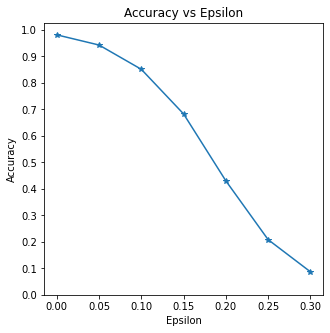

In [50]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

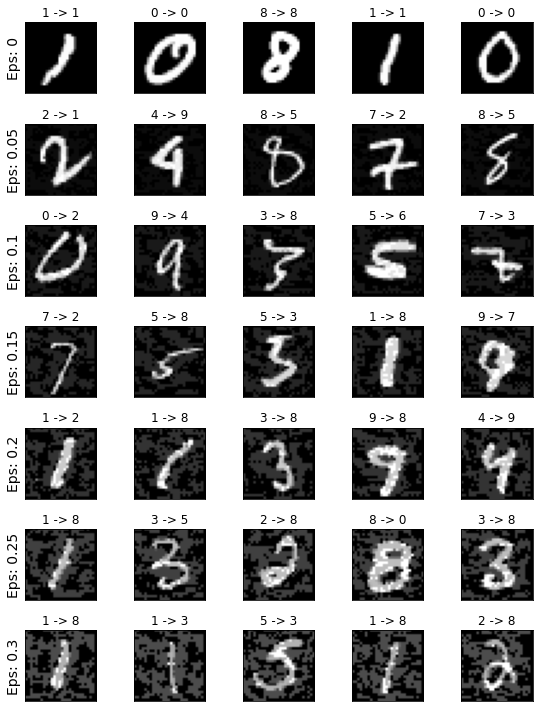

In [51]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

# One-Step target

In [64]:
epsilons = [0,.3,0.6,0.8,1,1.2]

In [65]:
def ost_attack(image, epsilon, data_grad):
  sign_data_grad = data_grad.sign()
  perturbed_image = image - epsilon*sign_data_grad
  perturbed_image = torch.clamp(perturbed_image, 0, 1)
  return perturbed_image

In [66]:
def test( model, device, test_loader, epsilon ):

    correct = 0
    adv_examples = []
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True


        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] 
        if init_pred.item() != target.item():
            continue

        loss = F.nll_loss(output, target)
        model.zero_grad()
        loss.backward()

        data_grad = data.grad.data
        perturbed_data = ost_attack(data, epsilon, data_grad)
        output = model(perturbed_data)
        final_pred = output.max(1, keepdim=True)[1] 
        if final_pred.item() == target.item():
            correct += 1
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
    return final_acc, adv_examples

In [67]:
accuracies = []
examples = []

for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.3	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.6	Test Accuracy = 9755 / 10000 = 0.9755
Epsilon: 0.8	Test Accuracy = 9415 / 10000 = 0.9415
Epsilon: 1	Test Accuracy = 8663 / 10000 = 0.8663
Epsilon: 1.2	Test Accuracy = 8663 / 10000 = 0.8663


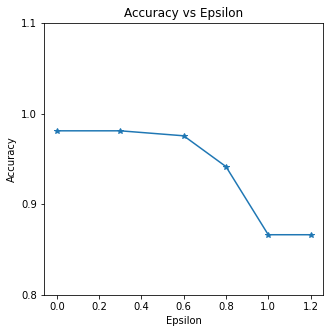

In [75]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0.8, 1.1, step=0.1))
plt.xticks(np.arange(0, 1.4, step=0.2))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

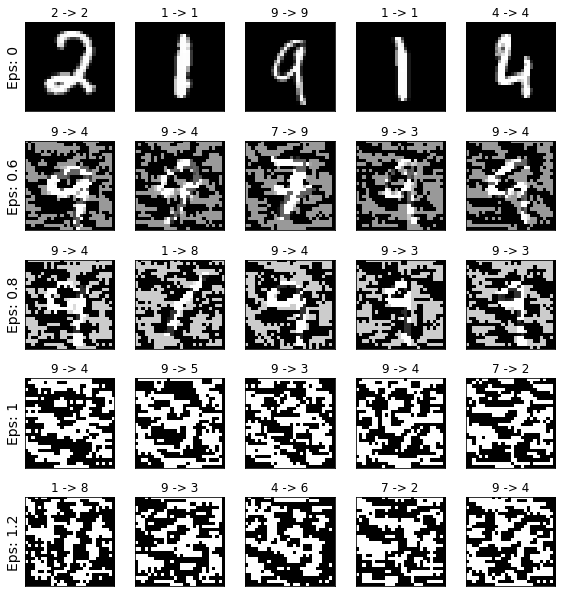

In [70]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

# Basic Iterative Method

In [76]:
epsilons = [0, .05, .1, .15, .2, .25, .3]

In [83]:
def basic_iterative_attack(image,target,epsilon,num_steps=5):
  image_org=image.detach().clone()
  for i in range(num_steps):
    output=model(image)
    loss = F.nll_loss(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = image.grad.data
    sign_data_grad = data_grad.sign()
    adv_temp = image + epsilon*sign_data_grad
    total_grad=adv_temp-image_org
    total_grad=torch.clamp(total_grad, -epsilon, epsilon)
    x_adv=image_org+total_grad
    image.data=x_adv
  return image

In [84]:
def test( model, device, test_loader, epsilon ):

    correct = 0
    adv_examples = []
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True


        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] 
        if init_pred.item() != target.item():
            continue


        perturbed_data = basic_iterative_attack(data,target,epsilon)
        output = model(perturbed_data)
        final_pred = output.max(1, keepdim=True)[1] 
        if final_pred.item() == target.item():
            correct += 1
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
    return final_acc, adv_examples

In [85]:
accuracies = []
examples = []

for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	Test Accuracy = 8698 / 10000 = 0.8698
Epsilon: 0.1	Test Accuracy = 4701 / 10000 = 0.4701
Epsilon: 0.15	Test Accuracy = 967 / 10000 = 0.0967
Epsilon: 0.2	Test Accuracy = 75 / 10000 = 0.0075
Epsilon: 0.25	Test Accuracy = 0 / 10000 = 0.0
Epsilon: 0.3	Test Accuracy = 0 / 10000 = 0.0


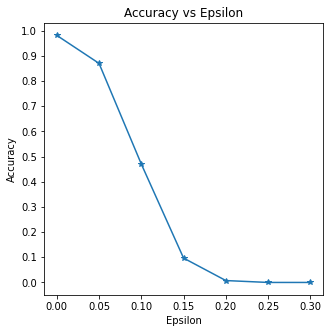

In [86]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

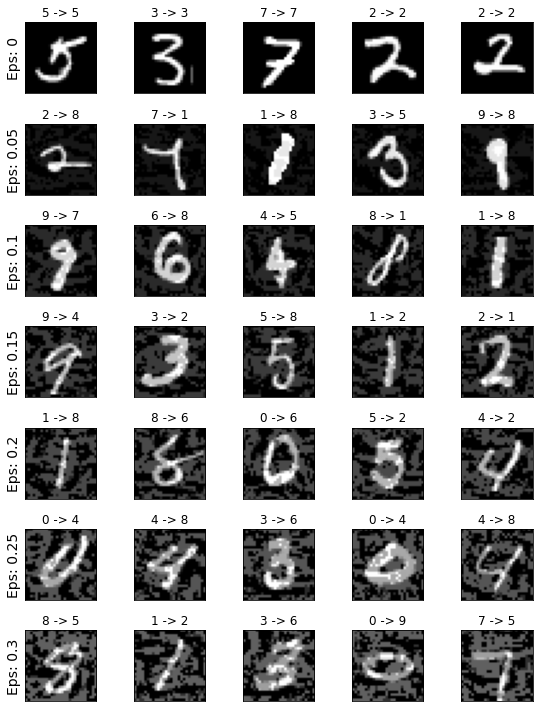

In [87]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()